# DNNにおけるearly-stoppingの導入

In [ ]:
【内容】  
- 5層のDNNでMNIST(数字画像)データの分類器を実装する
- 活性化関数をreluにする
- early-stoppingを実装する

【目標】  
- early-stoppingを実装するとオーバーフィッティングが緩和されることを確認する  
（学習時accuracyが100%近くにならない）

## ライブラリのインポート

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.initializers import TruncatedNormal

#tensorflowの互換性WARNING文の回避
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.FATAL)

np.random.seed(123)


Using TensorFlow backend.


## データの生成

In [2]:
# 研修用データロード
from mldata import mldata
X,Y,y,X_train,X_test,Y_train,Y_test, X_validation, Y_train, Y_validation = mldata.mldata2()

In [3]:
# # データロード
# # 使用するときは「ctrl+/」でコメントを外す

# mnist = datasets.fetch_openml('MNIST_784', version=1, return_X_y=False)

# n = len(mnist.data)
# N = 30000  # MNISTの一部を使う
# N_train = 20000
# N_validation = 4000
# indices = np.random.permutation(range(n))[:N]  # ランダムにN枚を選択

# X = mnist.data[indices]
# X = X / 255.0
# X = X - X.mean(axis=1).reshape(len(X), 1)
# y = mnist.target[indices]
# Y = np.eye(10)[y.astype(int)]

# X_train, X_test, Y_train, Y_test = \
#     train_test_split(X, Y, train_size=N_train)
# X_train, X_validation, Y_train, Y_validation = \
#     train_test_split(X_train, Y_train, test_size=N_validation)


## モデル設定

In [3]:
n_in = len(X[0])  # 784
n_hiddens = [200, 200, 200]
n_out = len(Y[0])  # 10
p_keep = 0.5
activation = 'relu'

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()
for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], input_dim=input_dim,
                    kernel_initializer=TruncatedNormal(stddev=0.01,seed=1234)))
    model.add(Activation(activation))
    model.add(Dropout(p_keep))

model.add(Dense(n_out, kernel_initializer=TruncatedNormal(stddev=0.01,seed=1234)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])


In [4]:
# モデルのサマリを確認する
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
__________

## モデル学習

In [5]:
epochs = 200
batch_size = 200

hist = model.fit(X_train, Y_train, epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(X_validation, Y_validation),
                 callbacks=[early_stopping])


Train on 16000 samples, validate on 4000 samples
Epoch 1/200
16000/16000 [==============================] - 2s 131us/step - loss: 1.4967 - acc: 0.4602 - val_loss: 0.7049 - val_acc: 0.7697
Epoch 2/200
16000/16000 [==============================] - 1s 69us/step - loss: 0.7119 - acc: 0.7707 - val_loss: 0.4648 - val_acc: 0.8673
Epoch 3/200
16000/16000 [==============================] - 1s 71us/step - loss: 0.5218 - acc: 0.8429 - val_loss: 0.3539 - val_acc: 0.9052
Epoch 4/200
16000/16000 [==============================] - 1s 70us/step - loss: 0.4295 - acc: 0.8763 - val_loss: 0.3113 - val_acc: 0.9155
Epoch 5/200
16000/16000 [==============================] - 1s 68us/step - loss: 0.3641 - acc: 0.8963 - val_loss: 0.2638 - val_acc: 0.9268
Epoch 6/200
16000/16000 [==============================] - 1s 69us/step - loss: 0.3108 - acc: 0.9122 - val_loss: 0.2312 - val_acc: 0.9325
Epoch 7/200
16000/16000 [==============================] - 1s 68us/step - loss: 0.2793 - acc: 0.9199 - val_loss: 0.2097 - 

## 学習の進み具合を可視化

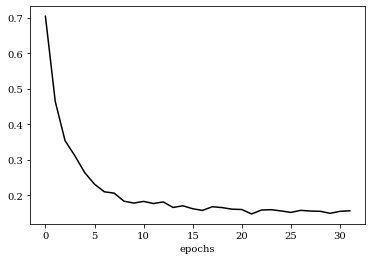

In [6]:
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, label='loss', color='black')
plt.xlabel('epochs')
plt.show()


## 予測精度の評価

In [7]:
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics)

10000/10000 [==============================] - 1s 60us/step
[0.1521982752321288, 0.9614]
